In [4]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

In [5]:
os.getcwd()

'/Users/klkusima/Desktop/RASH Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/Input data_KMC/KMC_output_varied_coverage'

In [6]:
%%time
Sim_folder_names = []
i = 0
for file in glob.glob("Sim_*"):
    Sim_folder_names.append(file)
    i+=1
print(i)
print(Sim_folder_names)
#os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

55
['Sim_A_0_B_77', 'Sim_A_44_B_55', 'Sim_A_55_B_22', 'Sim_A_22_B_77', 'Sim_A_88_B_11', 'Sim_A_22_B_22', 'Sim_A_33_B_0', 'Sim_A_33_B_55', 'Sim_A_0_B_22', 'Sim_A_22_B_0', 'Sim_A_66_B_11', 'Sim_A_11_B_44', 'Sim_A_11_B_88', 'Sim_A_11_B_11', 'Sim_A_0_B_100', 'Sim_A_77_B_11', 'Sim_A_11_B_33', 'Sim_A_11_B_66', 'Sim_A_66_B_33', 'Sim_A_44_B_0', 'Sim_A_44_B_22', 'Sim_A_55_B_0', 'Sim_A_100_B_0', 'Sim_A_22_B_55', 'Sim_A_0_B_55', 'Sim_A_33_B_22', 'Sim_A_33_B_66', 'Sim_A_0_B_11', 'Sim_A_44_B_33', 'Sim_A_55_B_44', 'Sim_A_66_B_0', 'Sim_A_0_B_0', 'Sim_A_22_B_11', 'Sim_A_55_B_11', 'Sim_A_22_B_44', 'Sim_A_33_B_33', 'Sim_A_0_B_88', 'Sim_A_0_B_44', 'Sim_A_11_B_22', 'Sim_A_66_B_22', 'Sim_A_11_B_77', 'Sim_A_77_B_0', 'Sim_A_88_B_0', 'Sim_A_11_B_0', 'Sim_A_11_B_55', 'Sim_A_77_B_22', 'Sim_A_44_B_44', 'Sim_A_0_B_66', 'Sim_A_33_B_11', 'Sim_A_22_B_66', 'Sim_A_55_B_33', 'Sim_A_22_B_33', 'Sim_A_44_B_11', 'Sim_A_0_B_33', 'Sim_A_33_B_44']
CPU times: user 1.72 ms, sys: 1.07 ms, total: 2.8 ms
Wall time: 1.97 ms


In [7]:
len(Sim_folder_names)

55

In [8]:
set_init_coverages = np.empty([len(Sim_folder_names),4])
#Remember: A='CO*'; B='O*'
#Reading A and B initial coverages from the KMC simulation input coverage files
c = 0 #counter
for s in Sim_folder_names:
    set_coverages = []
    for i in np.arange(len(s)):
        if i<(len(s)-2) and s[i].isdigit() and (s[i+1]).isdigit() and (s[i+2]).isdigit():
            cov_triple = int(s[i:i+3])
            set_coverages.append(cov_triple)
            
        elif i<(len(s)-1) and s[i].isdigit() and (s[i+1]).isdigit()and not((s[i-1]).isdigit()):
            cov_double = int(s[i:i+2])
            set_coverages.append(cov_double)
            
#             print(cov_double)
        elif s[i].isdigit() and not((s[i-1]).isdigit()) and not((s[i-2]).isdigit()):
            cov_single = int(s[i])
            set_coverages.append(cov_single)
                                #A_CO*_covg,     B_O*_covg,     O2*_covg,*_covg
    set_init_coverages[c,:] = [set_coverages[0],set_coverages[1],0,100-sum(set_coverages)]
    c+=1 #counter
#     set_coverages = [int(i) for i in s if i.isdigit()]
print(set_init_coverages)
#     print(s)

[[  0.  77.   0.  23.]
 [ 44.  55.   0.   1.]
 [ 55.  22.   0.  23.]
 [ 22.  77.   0.   1.]
 [ 88.  11.   0.   1.]
 [ 22.  22.   0.  56.]
 [ 33.   0.   0.  67.]
 [ 33.  55.   0.  12.]
 [  0.  22.   0.  78.]
 [ 22.   0.   0.  78.]
 [ 66.  11.   0.  23.]
 [ 11.  44.   0.  45.]
 [ 11.  88.   0.   1.]
 [ 11.  11.   0.  78.]
 [  0. 100.   0.   0.]
 [ 77.  11.   0.  12.]
 [ 11.  33.   0.  56.]
 [ 11.  66.   0.  23.]
 [ 66.  33.   0.   1.]
 [ 44.   0.   0.  56.]
 [ 44.  22.   0.  34.]
 [ 55.   0.   0.  45.]
 [100.   0.   0.   0.]
 [ 22.  55.   0.  23.]
 [  0.  55.   0.  45.]
 [ 33.  22.   0.  45.]
 [ 33.  66.   0.   1.]
 [  0.  11.   0.  89.]
 [ 44.  33.   0.  23.]
 [ 55.  44.   0.   1.]
 [ 66.   0.   0.  34.]
 [  0.   0.   0. 100.]
 [ 22.  11.   0.  67.]
 [ 55.  11.   0.  34.]
 [ 22.  44.   0.  34.]
 [ 33.  33.   0.  34.]
 [  0.  88.   0.  12.]
 [  0.  44.   0.  56.]
 [ 11.  22.   0.  67.]
 [ 66.  22.   0.  12.]
 [ 11.  77.   0.  12.]
 [ 77.   0.   0.  23.]
 [ 88.   0.   0.  12.]
 [ 11.   0.

In [9]:
os.getcwd()

'/Users/klkusima/Desktop/RASH Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/Input data_KMC/KMC_output_varied_coverage'

In [ ]:
#Checking to see match
## Copying all the other input files into the different simulation folders
# Extracting initial coverages
#Remember: A='CO*'; B='O*'
init_coverages = np.empty([len(Sim_folder_names),4])
c = 0 #counter
for s in Sim_folder_names:
    os.chdir(s)
    file=open('specnum_output.txt','r').readlines() #Reading in the relevant file
    b=[]
    for i in np.arange(len(file)): 
        b.append(file[i].split())                   #Dividing the rows into columns
    o = pd.DataFrame(data=b)                        #Final output

#     print(o)
    #Extracting Number of Sites from the general_output file:
    inp=open('general_output.txt','r').readlines()
    for i in np.arange(len(inp)): 
        if 'Total number of lattice sites:' in inp[i]:
            val = i  #Line in text file where sentence is present

    sites = int(inp[val][35:])
    
    #Finding number of surface species
    headings = (o.iloc[0,:])
    n_ss = sum('*' in h for h in headings) #Number of surface species
    
    #Finding number of gas species
    n_gs = len(headings)-5-n_ss
    
    #Adding column to calculate number of empty sites
    n_c=(len(o.iloc[0,:])) #number of current columns
    o[n_c]=" "           #Creating new empty column 
    o.iloc[0,n_c]="*"    #Labelling the new empty column 

    st = 0 #Initializing empty site coverage vector


    for i in range(len(o.iloc[1:])):
        if n_ss==0:
            site = sites
        else:
            for j in range(n_ss):
                st = st + float(o.iloc[i+1,5+j]) #Calculating no. of empty sites #Asuming empty sites are first to be reportes (i.e @5)
            site = sites - st
            st = 0
        o.iloc[i+1,n_c] = site
    
    Sspecies = []
    for i in range(n_ss):
        Sspecies.append(5+i) 
    Sspecies.append(len(o.iloc[1,:])-1)#Including empty sites

    #Calculating itme:
    Gtime = o[2][1:].astype(float) 
    #Calculating coverages:
    Scoverages = np.empty([len(o.iloc[:,1])-1,len(Sspecies)])
    for i in range(len(Scoverages[1,:])):
        Scoverages[:,i] = o[Sspecies[i]][1:].astype(float)/sites
        
    int_covg = [Scoverages[0,1],Scoverages[0,0],Scoverages[0,2],Scoverages[0,3]]
    print(int_covg)
                        #A_CO*_covg,     B_O*_covg,     O2*_covg,*_covg
    init_coverages[c,:]= [Scoverages[0,1],Scoverages[0,0],Scoverages[0,2],Scoverages[0,3]]
    
    c+=1
    
    os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

# Dictionary format:

In [10]:
#os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

In [11]:
%%time
## Copying all the other input files into the different simulation folders
# Extracting initial coverages
#Remember: A='CO*'; B='O*'
n = len(Sim_folder_names)
Covg = np.zeros((n,500,4)) #CO*, O*, O2*, *
Rates = np.zeros((n,500,3)) #CO, O2, CO2
KMC_time_Array = np.zeros((n,500))
init_coverages = np.empty([n,4])
c = 0 #counter for number of simulation (folders)

for s in Sim_folder_names:
    os.chdir(s)
    file=open('specnum_output.txt','r').readlines() #Reading in the relevant file
    b=[]
    for i in np.arange(len(file)): 
        b.append(file[i].split())                   #Dividing the rows into columns
    o = pd.DataFrame(data=b)                        #Final output

#     print(o)
    #Extracting Number of Sites from the general_output file:
    inp=open('general_output.txt','r').readlines()
    for i in np.arange(len(inp)): 
        if 'Total number of lattice sites:' in inp[i]:
            val = i  #Line in text file where sentence is present

    sites = int(inp[val][34:])
    
    #Finding number of surface species
    headings = (o.iloc[0,:])
    n_ss = sum('*' in h for h in headings) #Number of surface species
    
    #Finding number of gas species
    n_gs = len(headings)-5-n_ss
    
    #Adding column to calculate number of empty sites
    n_c=(len(o.iloc[0,:])) #number of current columns
    o[n_c]=" "           #Creating new empty column 
    o.iloc[0,n_c]="*"    #Labelling the new empty column 

    st = 0 #Initializing empty site coverage vector


    for i in range(len(o.iloc[1:])):
        if n_ss==0:
            site = sites
        else:
            for j in range(n_ss):
                st = st + float(o.iloc[i+1,5+j]) #Calculating no. of empty sites #Asuming empty sites are first to be reportes (i.e @5)
            site = sites - st
            st = 0
        o.iloc[i+1,n_c] = site
    
    Sspecies = []
    for i in range(n_ss):
        Sspecies.append(5+i) 
    Sspecies.append(len(o.iloc[1,:])-1)#Including empty sites

    #Calculating itme:
    Gtime = o[2][1:].astype(float) 
    #Calculating coverages:
    Scoverages = np.empty([len(o.iloc[:,1])-1,len(Sspecies)])
    for i in range(len(Scoverages[1,:])):
        Scoverages[:,i] = o[Sspecies[i]][1:].astype(float)/sites
        
    Gspecies = []
    for i in range(n_gs):
        Gspecies.append(5+n_ss+i) 
        
    #Extracting the number of gas species molecules:    
    Gnmol = np.empty([len(o.iloc[:,1])-1,len(Gspecies)])
    for i in range(len(Gnmol[1,:])):
        Gnmol[:,i] = o[Gspecies[i]][1:].astype(float)
    
    ### Calculating the instantaneous rates of profuction (i.e grad/sites)
    TOF_GS = np.empty([len(o.iloc[:,1])-1,len(Gspecies)]) #initializing an array of instantaneous TOFs for gaseous species
    # grads = np.empty([len(o.iloc[:,1])-1,1])
    for i in np.arange(len(Gspecies)):
        grads = np.gradient(Gnmol[:,i],Gtime,edge_order=2)
        TOF_GS[:,i] = grads/sites
    
    STOF_O2 = pd.Series(TOF_GS[:,0])
    STOF_CO = pd.Series(TOF_GS[:,1])
    STOF_CO2 = pd.Series(TOF_GS[:,2])
    Rates_p = pd.DataFrame(list(zip(STOF_CO, STOF_O2, STOF_CO2)),
                    columns =['R_CO', 'R_O2', 'R_CO2'])

    int_covg = [Scoverages[0,1],Scoverages[0,0],Scoverages[0,2],Scoverages[0,3]]
                        #A_CO*_covg,     B_O*_covg,     O2*_covg,         *_covg
    init_coverages[c,:]= [Scoverages[0,1],Scoverages[0,0],Scoverages[0,2],Scoverages[0,3]] #Initial coverages
    
    KMC_time_Array[c,:]= Gtime #Time matrix
     
    Covg[c,:,:] = Scoverages #Coverage profile tensor
    
    Rates[c,:,:] = Rates_p
    
    c+=1
    
    os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

#https://stackoverflow.com/questions/49881570/python-dictionaries-appending-arrays-to-a-dictionary-for-a-specific-key
data_KMC_dict = {'init_covg': init_coverages, 'sim_time': KMC_time_Array, 'covg_prof': Covg, 'iRates': Rates}

CPU times: user 3.61 s, sys: 46.1 ms, total: 3.65 s
Wall time: 3.8 s


# MKModel Data Gen

In [12]:
%%time
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.set_rxnconditions(Pr=[(1.0e-4*1.0e-5), (1.0e-4*0.1), 0])
MKM_init_coverages = np.empty([len(Sim_folder_names),4])


MKM_Covg = np.zeros((n,500,4)) #CO*, O*, O2*, *
MKM_Rates = np.zeros((n,500,3)) #CO, O2, CO2
time_MKM_Array = np.zeros((n,500))

#Remember: A='CO*'; B='O*'
#Reading A and B initial coverages from the KMC simulation input coverage file names!
c = 0 #counter
for s in Sim_folder_names:
    set_coverages = []
    for i in np.arange(len(s)):
        if i<(len(s)-2) and s[i].isdigit() and (s[i+1]).isdigit() and (s[i+2]).isdigit():
            cov_triple = int(s[i:i+3])
            set_coverages.append(cov_triple)
            
        elif i<(len(s)-1) and s[i].isdigit() and (s[i+1]).isdigit()and not((s[i-1]).isdigit()):
            cov_double = int(s[i:i+2])
            set_coverages.append(cov_double)
            
        elif s[i].isdigit() and not((s[i-1]).isdigit()) and not((s[i-2]).isdigit()):
            cov_single = int(s[i])
            set_coverages.append(cov_single)
                                #A_CO*_covg,     B_O*_covg,     O2*_covg,*_covg
    init_covgs = [set_coverages[0]/100,set_coverages[1]/100,0,(100-sum(set_coverages))/100]
    
    MKM.set_initial_coverages(init=init_covgs)
    MKM_init_coverages[c,:] = [float(i) for i in init_covgs]
    
    sola,solta = MKM.solve_coverage(Tf_eval=data_KMC_dict['sim_time'][0],plot=False)
    time_MKM_Array[c,:]= solta #Time matrix
    MKM_Covg[c,:,:] = sola #Coverage profile tensor
    
    solb,soltb = MKM.solve_rate_production(Tf_eval=data_KMC_dict['sim_time'][0],plot=False)
    MKM_Rates[c,:,:] = solb[:,0:3]

    c+=1 #counter

data_MKM_dict = {'init_covg': MKM_init_coverages, 'sim_time': time_MKM_Array, 'covg_prof': MKM_Covg, 'iRates': MKM_Rates}

Mass is conserved. 

CPU times: user 3min 18s, sys: 827 ms, total: 3min 19s
Wall time: 3min 18s


# Creating Features

## Calculating correction factor:

$$ corr_{fac} = ln\frac{r_{KMC}}{r_{MKM}}$$

In [13]:
len(Sim_folder_names)

55

In [14]:
Rates_size = np.shape(data_KMC_dict['iRates'])
Corr_fac = np.zeros((Rates_size[0],Rates_size[1],Rates_size[2])) 

In [15]:
import math
MKM_values = data_MKM_dict['iRates']
KMC_values = data_KMC_dict['iRates']

for i in np.arange(Rates_size[0]):
    for j in np.arange(Rates_size[1]):
        for k in np.arange(Rates_size[2]):
            num = KMC_values[i,j,k]
            den = MKM_values[i,j,k]
            frac = num/den
            #Preventing log(0)
            if float(num) == 0:
                num = 1e-20
            if float(den) == 0:
                den = 1e-20
                
            frac = num/den
            if float(frac) < 0: #(i.e the rates are either being calculated as consumed versus produced)
                frac = abs(frac)
                
            val = np.log(frac)
            Corr_fac[i,j,k] = val
            if math.isinf(val) or math.isnan(val):
                raise Exception('ERROR: inf or nan is present')

/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_6853/3103422064.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  frac = num/den
/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_6853/3103422064.py:10: RuntimeWarning: invalid value encountered in double_scalars
  frac = num/den


## Caluclating percent difference


$$ p_{diff} = \frac{|r_{MKM}-r_{KMC}|}{\frac{(r_{MKM}+r_{KMC})}{2}} $$

In [16]:
P_diff = np.zeros((Rates_size[0],Rates_size[1],Rates_size[2])) 

In [17]:
import math 
for i in np.arange(Rates_size[0]):
    for j in np.arange(Rates_size[1]):
        for k in np.arange(Rates_size[2]):
            mkmr = KMC_values[i,j,k]
            kmcr = MKM_values[i,j,k]      
            #Preventing nan
            if float(mkmr) == 0:
                mkmr = 1e-20
            if float(kmcr) == 0:
                kmcr = 1e-20
            val = abs(mkmr-kmcr)/((mkmr+kmcr)/2) 
            P_diff[i,j,k] = val
            if math.isinf(val) or math.isnan(val):
                raise Exception('ERROR: inf or nan is present')

# CREATING INPUT/FEATURE TENSOR

## Creating Simulation file names input

In [104]:
n=len(Sim_folder_names)
Sim_tens = np.empty((n,500,1),dtype=np.dtype('U100'))
for i in np.arange(n):
    for j in np.arange(500):
        Sim_tens[i,j,:] = Sim_folder_names[i]

## Creating Init coverages tensor input

In [105]:
n=len(Sim_folder_names)
s = np.shape(data_KMC_dict['init_covg'])[1]
ini_covg_tens = np.empty((n,500,s),dtype=float)
for i in np.arange(n):
    for j in np.arange(500):
        ini_covg_tens[i,j,:] = data_MKM_dict['init_covg'][i,:]

## Creating time tensor input

In [106]:
n=len(Sim_folder_names)
s = np.shape(data_KMC_dict['sim_time'])[1]
sim_time_tens = np.empty((n,s,1),dtype=float)
for i in np.arange(n):
    for z in np.arange(1):
        sim_time_tens[i,:,z] = data_MKM_dict['sim_time'][i,:]

# Merging Tensors into one input/feature/target dataframe

In [107]:
########################### Tensor for Simulation names
a = Sim_tens
m,n,r = a.shape
sim_name_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))

########################### Tensor for Initial coverage conditions
a = ini_covg_tens
m,n,r = a.shape
ini_covg_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))

########################### Tensor for Time
a = sim_time_tens
m,n,r = a.shape
sim_time_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))

########################### Tensor for coverage profiles
a = data_MKM_dict['covg_prof']
m,n,r = a.shape
Ext_covg_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))

########################### Tensor for instantaneous rates
a = data_MKM_dict['iRates']
m,n,r = a.shape
Ext_iRates_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))

########################### Tensor for Correction factors
a = Corr_fac
m,n,r = a.shape
out_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))
out_df = pd.DataFrame(out_arr,columns= ['Sim_ndex','Corr_fac_CO','Corr_fac_O2','Corr_fac_CO2'])


out_df.insert(1, "Sim_names", pd.DataFrame(sim_name_arr)[1])
out_df.insert(2, "Init_Covg_CO*", pd.DataFrame(ini_covg_arr)[1])
out_df.insert(3, "Init_Covg_O*", pd.DataFrame(ini_covg_arr)[2])
out_df.insert(4, "Init_Covg_O2*", pd.DataFrame(ini_covg_arr)[3])
out_df.insert(5, "Init_Covg_*", pd.DataFrame(ini_covg_arr)[4])
out_df.insert(6, "Time", pd.DataFrame(sim_time_arr)[1])
out_df.insert(7, "MKM_Covg_CO*", pd.DataFrame(MKM_covg_arr)[1])
out_df.insert(8, "MKM_Covg_O*", pd.DataFrame(MKM_covg_arr)[2])
out_df.insert(9, "MKM_Covg_O2*", pd.DataFrame(MKM_covg_arr)[3])
out_df.insert(10, "MKM_Covg_*", pd.DataFrame(MKM_covg_arr)[4])
out_df.insert(11, "MKM_iRate_CO", pd.DataFrame(MKM_iRates_arr)[1])
out_df.insert(12, "MKM_iRate_O2", pd.DataFrame(MKM_iRates_arr)[2])
out_df.insert(13, "MKM_iRate_CO2", pd.DataFrame(MKM_iRates_arr)[3])

########################### Tensor for Percent Difference
a = P_diff
m,n,r = a.shape
p_diff_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))
out_df.insert(14, "P_diff_CO", pd.DataFrame(p_diff_arr)[1])
out_df.insert(15, "P_diff_O2", pd.DataFrame(p_diff_arr)[2])
out_df.insert(16, "P_diff_CO2", pd.DataFrame(p_diff_arr)[3])

out_df.append(pd.DataFrame(p_diff_arr[:,1:],columns=['CO','O2','CO2']))
out_df

,Sim_ndex,Sim_names,Init_Covg_CO*,Init_Covg_O*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_CO*,MKM_Covg_O*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRate_CO,MKM_iRate_O2,MKM_iRate_CO2,P_diff_CO,P_diff_O2,P_diff_CO2,Corr_fac_CO,Corr_fac_O2,Corr_fac_CO2
0,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.0,0.000000e+00,0.770000,0.000000e+00,0.230000,-1.336300e-11,-0.001769,0.000000e+00,-2.0,-3.769858,2.0,20.697327,-1.181748,40.036521
1,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.1,1.273699e-12,0.768457,8.229311e-08,0.231543,-1.345262e-11,0.007683,1.321358e-12,-2.0,2.303915,2.0,20.844793,-2.650532,21.537851
2,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.2,2.430658e-12,0.766927,8.188720e-08,0.233073,-1.354156e-11,0.007625,2.516584e-12,-2.0,2.306423,2.0,21.002507,-2.642895,21.540236
3,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.3,3.482527e-12,0.765407,8.148674e-08,0.234592,-1.362982e-11,0.007567,3.598495e-12,-2.0,2.000000,2.0,20.996010,-41.167738,21.875769
4,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.4,4.440116e-12,0.763900,8.109164e-08,0.236100,-1.371742e-11,0.007510,4.578935e-12,-2.0,2.000000,2.0,20.910823,-41.160173,21.828975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27495,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.5,4.273505e-09,0.375505,2.819297e-08,0.624495,-3.628314e-11,-0.001560,2.166374e-09,-2.0,-1.764651,2.0,20.951226,2.772339,16.974247
27496,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.6,4.076327e-09,0.375816,2.821064e-08,0.624184,-3.626504e-11,-0.001556,2.068133e-09,-2.0,-1.798299,2.0,20.981053,2.935524,16.846809
27497,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.7,3.884579e-09,0.376127,2.822827e-08,0.623873,-3.624699e-11,-0.001551,1.972479e-09,-2.0,-1.804014,2.0,20.952223,2.965767,16.961468
27498,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.8,3.711044e-09,0.376437,2.824589e-08,0.623563,-3.622899e-11,-0.001547,1.885915e-09,-2.0,-1.756567,2.0,21.043692,2.736419,17.091383


***
# Extracting Input and Output

In [108]:
All_columns = out_df.columns.to_list()
target_columns = list(filter(lambda x: ('Corr') in x or ('P_diff') in x, All_columns))

input_columns = [colmn for colmn in All_columns if colmn not in target_columns]

In [109]:
X_all = out_df[input_columns] #Ignoring the first two columns(index and simulation name)

In [110]:
Y_all = out_df[['Sim_ndex','Sim_names']+target_columns]

In [111]:
X_all

,Sim_ndex,Sim_names,Init_Covg_CO*,Init_Covg_O*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_CO*,MKM_Covg_O*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRate_CO,MKM_iRate_O2,MKM_iRate_CO2
0,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.0,0.000000e+00,0.770000,0.000000e+00,0.230000,-1.336300e-11,-0.001769,0.000000e+00
1,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.1,1.273699e-12,0.768457,8.229311e-08,0.231543,-1.345262e-11,0.007683,1.321358e-12
2,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.2,2.430658e-12,0.766927,8.188720e-08,0.233073,-1.354156e-11,0.007625,2.516584e-12
3,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.3,3.482527e-12,0.765407,8.148674e-08,0.234592,-1.362982e-11,0.007567,3.598495e-12
4,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.4,4.440116e-12,0.763900,8.109164e-08,0.236100,-1.371742e-11,0.007510,4.578935e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27495,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.5,4.273505e-09,0.375505,2.819297e-08,0.624495,-3.628314e-11,-0.001560,2.166374e-09
27496,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.6,4.076327e-09,0.375816,2.821064e-08,0.624184,-3.626504e-11,-0.001556,2.068133e-09
27497,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.7,3.884579e-09,0.376127,2.822827e-08,0.623873,-3.624699e-11,-0.001551,1.972479e-09
27498,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.8,3.711044e-09,0.376437,2.824589e-08,0.623563,-3.622899e-11,-0.001547,1.885915e-09


# Extracting Train and Test Split

In [527]:
import random
p_test = 0.1 #Percent test data
print('Percent of test data selected:',p_test*100,'%')

max_sim_number = X_all[input_columns[0]].iloc[-1] #MAx_number of simulations present #Count is starting from 0
val = int(p_test*max_sim_number)

# Generate a random starting number in the range of present simulations
start_num = random.randint(0, max_sim_number-val)

# Create a list of 5 consecutive numbers starting from the random starting number
test_sim_range = list(range(start_num, start_num + val))

print('\n','The list of simulations used in the test dataset:\n',test_sim_range)

X_test = X_all.loc[(min(test_sim_range)<=X_all.Sim_ndex) & (X_all.Sim_ndex <= max(test_sim_range))]
Y_test = Y_all.loc[(min(test_sim_range)<=Y_all.Sim_ndex) & (Y_all.Sim_ndex <= max(test_sim_range))]

X_train = X_all[~X_all['Sim_ndex'].isin(test_sim_range)]
Y_train = Y_all[~Y_all['Sim_ndex'].isin(test_sim_range)]

Percent of test data selected: 10.0 %

 The list of simulations used in the test dataset:
 [3, 4, 5, 6, 7]


In [528]:
X_test

,Sim_ndex,Sim_names,Init_Covg_CO*,Init_Covg_O*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_CO*,MKM_Covg_O*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRate_CO,MKM_iRate_O2,MKM_iRate_CO2
1500,3.0,Sim_A_22_B_77,0.22,0.77,0.0,0.01,0.0,2.200000e-01,0.770000,0.000000e+00,0.010000,1.462419e-09,-0.000077,2.286900e-01
1501,3.0,Sim_A_22_B_77,0.22,0.77,0.0,0.01,0.1,1.986039e-01,0.746317,9.544697e-08,0.055079,1.317516e-09,0.010553,2.000991e-01
1502,3.0,Sim_A_22_B_77,0.22,0.77,0.0,0.01,0.2,1.798260e-01,0.725575,8.591790e-08,0.094599,1.190347e-09,0.009153,1.761443e-01
1503,3.0,Sim_A_22_B_77,0.22,0.77,0.0,0.01,0.3,1.632523e-01,0.707285,7.870969e-08,0.129463,1.078106e-09,0.008056,1.558789e-01
1504,3.0,Sim_A_22_B_77,0.22,0.77,0.0,0.01,0.4,1.485512e-01,0.691064,7.309112e-08,0.160385,9.785474e-10,0.007172,1.385888e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,7.0,Sim_A_33_B_55,0.33,0.55,0.0,0.12,49.5,4.565761e-10,0.410603,3.034706e-08,0.589397,-3.424396e-11,-0.001043,2.530866e-10
3996,7.0,Sim_A_33_B_55,0.33,0.55,0.0,0.12,49.6,4.755176e-10,0.410811,3.036086e-08,0.589189,-3.423186e-11,-0.001039,2.637198e-10
3997,7.0,Sim_A_33_B_55,0.33,0.55,0.0,0.12,49.7,4.936989e-10,0.411019,3.037463e-08,0.588981,-3.421980e-11,-0.001036,2.739414e-10
3998,7.0,Sim_A_33_B_55,0.33,0.55,0.0,0.12,49.8,5.108094e-10,0.411226,3.038837e-08,0.588774,-3.420778e-11,-0.001033,2.835782e-10


In [529]:
X_train

,Sim_ndex,Sim_names,Init_Covg_CO*,Init_Covg_O*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_CO*,MKM_Covg_O*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRate_CO,MKM_iRate_O2,MKM_iRate_CO2
0,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.0,0.000000e+00,0.770000,0.000000e+00,0.230000,-1.336300e-11,-0.001769,0.000000e+00
1,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.1,1.273699e-12,0.768457,8.229311e-08,0.231543,-1.345262e-11,0.007683,1.321358e-12
2,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.2,2.430658e-12,0.766927,8.188720e-08,0.233073,-1.354156e-11,0.007625,2.516584e-12
3,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.3,3.482527e-12,0.765407,8.148674e-08,0.234592,-1.362982e-11,0.007567,3.598495e-12
4,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.4,4.440116e-12,0.763900,8.109164e-08,0.236100,-1.371742e-11,0.007510,4.578935e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27495,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.5,4.273505e-09,0.375505,2.819297e-08,0.624495,-3.628314e-11,-0.001560,2.166374e-09
27496,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.6,4.076327e-09,0.375816,2.821064e-08,0.624184,-3.626504e-11,-0.001556,2.068133e-09
27497,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.7,3.884579e-09,0.376127,2.822827e-08,0.623873,-3.624699e-11,-0.001551,1.972479e-09
27498,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.8,3.711044e-09,0.376437,2.824589e-08,0.623563,-3.622899e-11,-0.001547,1.885915e-09


In [530]:
Y_all[['Sim_ndex','P_diff_CO','P_diff_O2','P_diff_CO2']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27500 entries, 0 to 27499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sim_ndex    27500 non-null  float64
 1   P_diff_CO   27500 non-null  float64
 2   P_diff_O2   27500 non-null  float64
 3   P_diff_CO2  27500 non-null  float64
dtypes: float64(4)
memory usage: 859.5 KB


In [531]:
#REMOVING THE SIM_NDEX AND SIM_NAMES COLUMNS\
X_test = X_test.drop(columns=['Sim_ndex','Sim_names'])
Y_test = Y_test.drop(columns=['Sim_ndex','Sim_names'])

X_train = X_train.drop(columns=['Sim_ndex','Sim_names'])
Y_train = Y_train.drop(columns=['Sim_ndex','Sim_names'])

In [532]:
X_train

,Init_Covg_CO*,Init_Covg_O*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_CO*,MKM_Covg_O*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRate_CO,MKM_iRate_O2,MKM_iRate_CO2
0,0.00,0.77,0.0,0.23,0.0,0.000000e+00,0.770000,0.000000e+00,0.230000,-1.336300e-11,-0.001769,0.000000e+00
1,0.00,0.77,0.0,0.23,0.1,1.273699e-12,0.768457,8.229311e-08,0.231543,-1.345262e-11,0.007683,1.321358e-12
2,0.00,0.77,0.0,0.23,0.2,2.430658e-12,0.766927,8.188720e-08,0.233073,-1.354156e-11,0.007625,2.516584e-12
3,0.00,0.77,0.0,0.23,0.3,3.482527e-12,0.765407,8.148674e-08,0.234592,-1.362982e-11,0.007567,3.598495e-12
4,0.00,0.77,0.0,0.23,0.4,4.440116e-12,0.763900,8.109164e-08,0.236100,-1.371742e-11,0.007510,4.578935e-12
...,...,...,...,...,...,...,...,...,...,...,...,...
27495,0.33,0.44,0.0,0.23,49.5,4.273505e-09,0.375505,2.819297e-08,0.624495,-3.628314e-11,-0.001560,2.166374e-09
27496,0.33,0.44,0.0,0.23,49.6,4.076327e-09,0.375816,2.821064e-08,0.624184,-3.626504e-11,-0.001556,2.068133e-09
27497,0.33,0.44,0.0,0.23,49.7,3.884579e-09,0.376127,2.822827e-08,0.623873,-3.624699e-11,-0.001551,1.972479e-09
27498,0.33,0.44,0.0,0.23,49.8,3.711044e-09,0.376437,2.824589e-08,0.623563,-3.622899e-11,-0.001547,1.885915e-09


In [533]:
Y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 27499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   P_diff_CO     25000 non-null  float64
 1   P_diff_O2     25000 non-null  float64
 2   P_diff_CO2    25000 non-null  float64
 3   Corr_fac_CO   25000 non-null  float64
 4   Corr_fac_O2   25000 non-null  float64
 5   Corr_fac_CO2  25000 non-null  float64
dtypes: float64(6)
memory usage: 1.3 MB


In [534]:
X_train

,Init_Covg_CO*,Init_Covg_O*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_CO*,MKM_Covg_O*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRate_CO,MKM_iRate_O2,MKM_iRate_CO2
0,0.00,0.77,0.0,0.23,0.0,0.000000e+00,0.770000,0.000000e+00,0.230000,-1.336300e-11,-0.001769,0.000000e+00
1,0.00,0.77,0.0,0.23,0.1,1.273699e-12,0.768457,8.229311e-08,0.231543,-1.345262e-11,0.007683,1.321358e-12
2,0.00,0.77,0.0,0.23,0.2,2.430658e-12,0.766927,8.188720e-08,0.233073,-1.354156e-11,0.007625,2.516584e-12
3,0.00,0.77,0.0,0.23,0.3,3.482527e-12,0.765407,8.148674e-08,0.234592,-1.362982e-11,0.007567,3.598495e-12
4,0.00,0.77,0.0,0.23,0.4,4.440116e-12,0.763900,8.109164e-08,0.236100,-1.371742e-11,0.007510,4.578935e-12
...,...,...,...,...,...,...,...,...,...,...,...,...
27495,0.33,0.44,0.0,0.23,49.5,4.273505e-09,0.375505,2.819297e-08,0.624495,-3.628314e-11,-0.001560,2.166374e-09
27496,0.33,0.44,0.0,0.23,49.6,4.076327e-09,0.375816,2.821064e-08,0.624184,-3.626504e-11,-0.001556,2.068133e-09
27497,0.33,0.44,0.0,0.23,49.7,3.884579e-09,0.376127,2.822827e-08,0.623873,-3.624699e-11,-0.001551,1.972479e-09
27498,0.33,0.44,0.0,0.23,49.8,3.711044e-09,0.376437,2.824589e-08,0.623563,-3.622899e-11,-0.001547,1.885915e-09


In [535]:
Y_train

,P_diff_CO,P_diff_O2,P_diff_CO2,Corr_fac_CO,Corr_fac_O2,Corr_fac_CO2
0,-2.0,-3.769858,2.0,20.697327,-1.181748,40.036521
1,-2.0,2.303915,2.0,20.844793,-2.650532,21.537851
2,-2.0,2.306423,2.0,21.002507,-2.642895,21.540236
3,-2.0,2.000000,2.0,20.996010,-41.167738,21.875769
4,-2.0,2.000000,2.0,20.910823,-41.160173,21.828975
...,...,...,...,...,...,...
27495,-2.0,-1.764651,2.0,20.951226,2.772339,16.974247
27496,-2.0,-1.798299,2.0,20.981053,2.935524,16.846809
27497,-2.0,-1.804014,2.0,20.952223,2.965767,16.961468
27498,-2.0,-1.756567,2.0,21.043692,2.736419,17.091383


# Training the model

In [611]:
%%time
import xgboost as xgb
from sklearn.metrics import mean_squared_error

reg = xgb.XGBRegressor(booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:linear',
                       max_depth=15,
                       learning_rate=0.01)
reg.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train)],
        verbose=50)

[17:18:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11.62398
[50]	validation_0-rmse:7.67089
[100]	validation_0-rmse:5.21531
[150]	validation_0-rmse:3.65880
[200]	validation_0-rmse:2.64472
[250]	validation_0-rmse:1.96033
[300]	validation_0-rmse:1.48189
[350]	validation_0-rmse:1.13703
[400]	validation_0-rmse:0.88255
[450]	validation_0-rmse:0.69105
[500]	validation_0-rmse:0.54439
[550]	validation_0-rmse:0.43084
[600]	validation_0-rmse:0.34379
[650]	validation_0-rmse:0.27709
[700]	validation_0-rmse:0.22639
[750]	validation_0-rmse:0.18817
[800]	validation_0-rmse:0.15884
[850]	validation_0-rmse:0.13612
[900]	validation_0-rmse:0.11803
[950]	validation_0-rmse:0.10513
[999]	validation_0-rmse:0.09626
CPU times: user 13min 36s, sys: 1min 41s, total: 15min 18s
Wall time: 2min 21s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [672]:
%%time
import tensorflow as tf

from tensorflow.keras import models, datasets, layers, optimizers, initializers
from keras.layers import Dropout, BatchNormalization

a,b = X_train.values.shape
c,d = Y_train.values.shape


reg = models.Sequential()
reg.add(layers.Flatten(input_shape=(b,)))
for s in range(4): #Number of hidden layers
    reg.add(layers.Dense(64, activation= 'relu', #Number of hidden layer neurons in each layer
                         kernel_initializer=tf.keras.initializers.Constant(1.),
                         bias_initializer=tf.keras.initializers.Constant(1.), 
                         kernel_regularizer = tf.keras.regularizers.L2(1e-4)))

reg.add(layers.BatchNormalization(epsilon=0.1))
reg.add(layers.Dense(d, activation='relu'))


reg.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                 loss='MeanAbsoluteError',
                 metrics=['RootMeanSquaredError'])

reg.fit(X_train, Y_train, epochs=100,verbose=False)

CPU times: user 1min 42s, sys: 25.4 s, total: 2min 7s
Wall time: 1min 4s


In [673]:
#Quick Model Evaluation on Test Data
Y_pred = reg.predict(X_test)

np.sqrt(mean_squared_error(Y_test, Y_pred))

79/79 [==============================] - 0s 1ms/step


3.147554963821

In [ ]:
%%time
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

def create_network(optimizer='rmsprop', neurons=16, learning_rate=0.001):
    
    # Start Artificial Neural Network
    network = models.Sequential()
    
    network.add(layers.Flatten(input_shape=(b,)))
    
    # Adding the input layer and the first hidden layer
    network.add(layers.Dense(units = neurons, 
                  activation = tf.keras.layers.LeakyReLU(alpha=0.3)))

    # Adding the second hidden layer
    network.add(layers.Dense(units = neurons, 
                  activation = tf.keras.layers.LeakyReLU(alpha=0.3)))

    # Adding the third hidden layer
    network.add(layers.Dense(units = neurons, 
                  activation = tf.keras.layers.LeakyReLU(alpha=0.3)))

    # Adding the output layer
    network.add(layers.Dense(d))

    ###############################################
    # Add optimizer with learning rate
    if optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        raise ValueError('optimizer {} unrecognized'.format(optimizer))
    ##############################################    

    # Compile NN
    network.compile(optimizer = opt, 
                loss = 'mean_squared_error', 
                metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
    
    # Return compiled network
    return network

# Wrap Keras model so it can be used by scikit-learn
ann = KerasRegressor(build_fn=create_network, verbose=0)

# Create hyperparameter space
epoch_values = [10, 25, 50, 100, 150, 200]
batches = [10, 20, 30, 40, 50, 100, 1000]
optimizers = ['rmsprop', 'adam', 'SGD']
neuron_list = [16, 32, 64, 128, 256]
lr_values = [0.001, 0.01, 0.1, 0.2, 0.3]

# Create hyperparameter options
hyperparameters = dict(
    epochs=epoch_values, 
    batch_size=batches, 
    optimizer=optimizers, 
    neurons=neuron_list,
    learning_rate=lr_values)

# Create grid search
# cv=5 is the default 5-fold
grid = GridSearchCV(estimator=ann, cv=5, param_grid=hyperparameters)

# Fit grid search
grid_result = grid.fit(X_train, Y_train)


<timed exec>:47: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
grid.best_params_

In [ ]:
Y_pred = grid.predict(X_test)

np.sqrt(mean_squared_error(Y_test, Y_pred))

In [674]:
KMC_Data_EXP = pd.read_csv('KMC_NonDynamic_Data_iCovg_iRates.csv')
KMC_Data_EXP_rates= KMC_Data_EXP.iloc[:,-3:] #To be used to later to compare and asses ML prediction results

test_data_ini_cov = KMC_Data_EXP.iloc[0,1:5].values
test_data_time_interv = KMC_Data_EXP.iloc[:,0].values
matrix_test_data_ini_cov = np.empty((len(test_data_time_interv),len(test_data_ini_cov)))
for i in np.arange(len(test_data_time_interv)):
    matrix_test_data_ini_cov[i] = test_data_ini_cov


***
# Using the Model

In [675]:
%%time
from main import *
MKM_test_inp = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM_test_inp.set_rxnconditions(Pr=[(1.0e-4*1.0e-5), (1.0e-4*0.1), 0])

MKM_Covg_test_inp = np.zeros((len(test_data_time_interv),len(test_data_ini_cov))) #CO*, O*, O2*, *
MKM_Rates_test_inp = np.zeros((len(test_data_time_interv),3)) #CO, O2, CO2

MKM_test_inp.set_initial_coverages(init=test_data_ini_cov)

sola,solta = MKM_test_inp.solve_coverage(Tf_eval=test_data_time_interv,plot=False)
MKM_Covg_test_inp = sola #Coverage profile matrix

solb,soltb = MKM_test_inp.solve_rate_production(Tf_eval=test_data_time_interv,plot=False)
MKM_Rates_test_inp = solb[:,0:3]

np.shape(MKM_Rates_test_inp)

Mass is conserved. 

CPU times: user 1.66 s, sys: 10 ms, total: 1.67 s
Wall time: 1.69 s


(251, 3)

In [676]:
Test_input = pd.DataFrame({'Time': test_data_time_interv})
Test_input.insert(0, "Init_Covg_CO*", pd.DataFrame(matrix_test_data_ini_cov)[0])
Test_input.insert(1, "Init_Covg_O*", pd.DataFrame(matrix_test_data_ini_cov)[1])
Test_input.insert(2, "Init_Covg_O2*", pd.DataFrame(matrix_test_data_ini_cov)[2])
Test_input.insert(3, "Init_Covg_*", pd.DataFrame(matrix_test_data_ini_cov)[3])
Test_input.insert(5, "MKM_Covg_CO*", pd.DataFrame(MKM_Covg_test_inp)[0])
Test_input.insert(6, "MKM_Covg_O*", pd.DataFrame(MKM_Covg_test_inp)[1])
Test_input.insert(7, "MKM_Covg_O2*", pd.DataFrame(MKM_Covg_test_inp)[2])
Test_input.insert(8, "MKM_Covg_*", pd.DataFrame(MKM_Covg_test_inp)[3])
Test_input.insert(9, "MKM_iRate_CO", pd.DataFrame(MKM_Rates_test_inp)[0])
Test_input.insert(10, "MKM_iRate_O2", pd.DataFrame(MKM_Rates_test_inp)[1])
Test_input.insert(11, "MKM_iRate_CO2", pd.DataFrame(MKM_Rates_test_inp)[2])
Test_input.head(10)

,Init_Covg_CO*,Init_Covg_O*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_CO*,MKM_Covg_O*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRate_CO,MKM_iRate_O2,MKM_iRate_CO2
0,0.0,0.0,0.0,1.0,0.0,0.000000e+00,0.000000,0.000000e+00,1.000000,-5.810000e-11,-0.007690,0.000000e+00
1,0.0,0.0,0.0,1.0,0.1,5.806549e-12,0.001066,2.050003e-08,0.998934,-5.803809e-11,-0.005324,8.352829e-15
2,0.0,0.0,0.0,1.0,0.2,1.160508e-11,0.002130,2.049351e-08,0.997870,-5.797626e-11,-0.005317,3.336550e-14
3,0.0,0.0,0.0,1.0,0.3,1.739410e-11,0.003192,2.048713e-08,0.996808,-5.791453e-11,-0.005309,7.496209e-14
4,0.0,0.0,0.0,1.0,0.4,2.316969e-11,0.004253,2.048087e-08,0.995747,-5.785287e-11,-0.005302,1.330442e-13
5,0.0,0.0,0.0,1.0,0.5,2.893024e-11,0.005313,2.047475e-08,0.994687,-5.779131e-11,-0.005295,2.075079e-13
6,0.0,0.0,0.0,1.0,0.6,3.467768e-11,0.006371,2.046875e-08,0.993629,-5.772983e-11,-0.005287,2.982703e-13
7,0.0,0.0,0.0,1.0,0.7,4.041199e-11,0.007428,2.046288e-08,0.992572,-5.766843e-11,-0.005280,4.052405e-13
8,0.0,0.0,0.0,1.0,0.8,4.612287e-11,0.008483,2.045713e-08,0.991517,-5.760713e-11,-0.005272,5.282094e-13
9,0.0,0.0,0.0,1.0,0.9,5.181572e-11,0.009537,2.045152e-08,0.990463,-5.754591e-11,-0.005265,6.671123e-13


In [677]:
#Quick Model Evaluation on Test Data
Test_output = reg.predict(Test_input)

Pred_corr = Test_output[:,3:] #extracting correction factors #CO #O2 #CO2

8/8 [==============================] - 0s 700us/step


In [678]:
#Calculating extracted ML predicted rates
MKM_Rates_pred = np.zeros((len(test_data_time_interv),3)) #CO, O2, CO2
for i in np.arange(np.shape(MKM_Rates_pred)[0]):
    for j in np.arange(np.shape(MKM_Rates_pred)[1]):
        MKM_Rates_pred[i,j] = MKM_Rates_test_inp[i,j]*np.exp(Pred_corr[i,j])

<IPython.core.display.Javascript object>


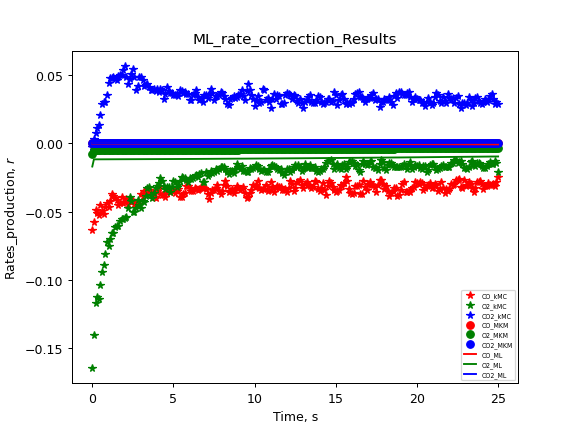

In [679]:
%matplotlib notebook
plt.figure()
plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,0],'r*', label='CO_kMC')        
plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,1],'g*', label='O2_kMC') 
plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,2], 'b*', label='CO2_kMC') 

plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,0],'ro', label='CO_MKM')        
plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,1],'go', label='O2_MKM') 
plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,2], 'bo', label='CO2_MKM') 

plt.plot(test_data_time_interv, MKM_Rates_pred[:,0],'r-', label='CO_ML')        
plt.plot(test_data_time_interv, MKM_Rates_pred[:,1],'g-', label='O2_ML') 
plt.plot(test_data_time_interv, MKM_Rates_pred[:,2], 'b-', label='CO2_ML') 

plt.xlabel('Time, s')
plt.ylabel("Rates_production, $r$")
plt.title('ML_rate_correction_Results')
plt.legend(fontsize=5, loc='best')
plt.show()